In [1]:
import os
import pathlib

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf 
import tensorflow_io as tfio
import scipy.signal as signal

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import seaborn as sns

import librosa
import librosa.display
import IPython

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def get_label(file_path):
    parts = tf.strings.split( input=file_path, sep=os.path.sep )
    return parts[-2]

In [5]:
def load_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)

    # Convert audio to mono channel and normalize
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    
    return audio

In [6]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    waveform = load_audio(file_path)
    return waveform, label

KROK 2

In [7]:
def get_label_id(label: str):
    return tf.argmax(label == COMMANDS)

In [8]:
def get_spectrogram(waveform):
    
    n_fft = N_FFT
    hop_length = HOP_LENGTH
    n_mels = N_MELS

    f_min = F_MIN
    f_max = F_MAX
    
    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(waveform, nfft=n_fft, window=n_fft, stride=n_mels)
      
    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SR, mels=n_mels, fmin=f_min, fmax=f_max)
    # Convert to db scale mel-spectrogram
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    dbscale_mel_spectrogram = dbscale_mel_spectrogram[..., tf.newaxis]
    #    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return dbscale_mel_spectrogram

In [9]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = get_label_id(label)
    return spectrogram, label_id

KROK 3

In [10]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    
    output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
    
    output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
    
    return output_ds

In [11]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = spectrogram.T + np.finfo(float).eps
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

POBRANIE PLIKÓW AUDIO

In [12]:
SR = 16000
F_MIN = 100
F_MAX = 8000

N_FFT = int(0.05 * SR)  # 25 ms, 50ms
HOP_LENGTH = int(0.02 * SR)  # 10 ms
N_MELS = 128


DURATION = 2.0
PRE_EMPHASIS = 0.97
N_MFCC = 40

DATASET_DIR = '..\\..\\Python Projects\\VoiceCommandClassification\\DATA\\data_aug_23'
DATASET_PATH = pathlib.Path(DATASET_DIR)
COMMANDS = []
FILENAMES = []

In [13]:
FILENAMES = tf.io.gfile.glob(str(DATASET_PATH)+'/*/*.wav')


filenames_len = len(FILENAMES)
print('Liczba wszystkich próbek : ', filenames_len)

COMMANDS = np.array(tf.io.gfile.listdir(str(DATASET_PATH)))

for command in COMMANDS:
    print(command, len(tf.io.gfile.glob( str(os.path.join(DATASET_PATH, command)) + '/*.wav')))
    

Liczba wszystkich próbek :  12337
00-odrzuc_bron 2350
01-obroc_sie 2420
02-na_kolana 2340
03-gleba 2360
04-rece_na_glowe 2380
05-tlo 487


lengths = []
for file_name in FILENAMES:
    wav = load_audio(file_name)
    lengths.append(len(wav))

array = np.array(lengths)
print(array.min())
print(array.max())
print(array.mean())


PRZYGOTOWANIE ZESTAWÓW 

In [14]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

FILENAMES = tf.random.shuffle(FILENAMES)

train_num = 0.8
val_num = 0.2
#test_num = 0.1

train_files = FILENAMES[:int(filenames_len*train_num)]
val_files = FILENAMES[int(filenames_len*train_num) : int(filenames_len*train_num) + int(filenames_len*val_num)]
#test_files = FILENAMES[int(filenames_len*train_num) + int(filenames_len*val_num):]

AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
#test_ds = preprocess_dataset(test_files)

In [15]:
input_shape = 0
for spectrogram, _ in train_ds.take(1):
    input_shape = spectrogram.shape
    
num_labels = len(COMMANDS)

print('Input shape:', input_shape)
print('Classes:', num_labels)

Input shape: (375, 128, 1)
Classes: 6


In [16]:
batch_size = 64

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

#Dataset.cache i Dataset.prefetch , aby zmniejszyć opóźnienie odczytu podczas uczenia modelu:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [17]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))



In [19]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 375, 128, 1)      3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 373, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 186, 63, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 184, 61, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 92, 30, 32)       0         
 2D)                                                             
                                                        

model2.add(Conv2D(filters=32, kernel_size=(7,7), padding='same', activation='relu', input_shape=(256, 256, 1)))
model2.add(Conv2D(filters=32, kernel_size=(7,7), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
 
model2.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
 
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
 
model2.add(Flatten())
 
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.33))
 
model2.add(Dense(2, activation='softmax'))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(128, 128),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [21]:
EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
155/155 [==============================] - 181s 1s/step - loss: 1.1009 - accuracy: 0.5714 - val_loss: 0.3888 - val_accuracy: 0.8816
Epoch 2/100
155/155 [==============================] - 82s 529ms/step - loss: 0.3507 - accuracy: 0.8894 - val_loss: 0.2105 - val_accuracy: 0.9299
Epoch 3/100
155/155 [==============================] - 128s 828ms/step - loss: 0.1966 - accuracy: 0.9347 - val_loss: 0.1604 - val_accuracy: 0.9473
Epoch 4/100
155/155 [==============================] - 128s 828ms/step - loss: 0.1099 - accuracy: 0.9643 - val_loss: 0.1006 - val_accuracy: 0.9651
Epoch 5/100
155/155 [==============================] - 128s 827ms/step - loss: 0.0870 - accuracy: 0.9717 - val_loss: 0.1084 - val_accuracy: 0.9672
Epoch 6/100
155/155 [==============================] - 128s 827ms/step - loss: 0.0619 - accuracy: 0.9787 - val_loss: 0.0928 - val_accuracy: 0.9660
Epoch 7/100
155/155 [==============================] - 76s 490ms/step - loss: 0.0448 - accuracy: 0.9854 - val_loss: 0.0886

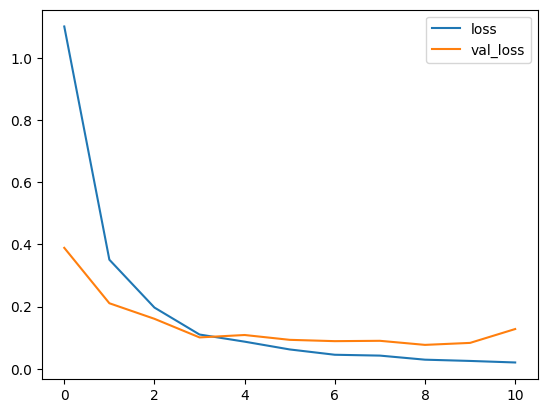

In [22]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

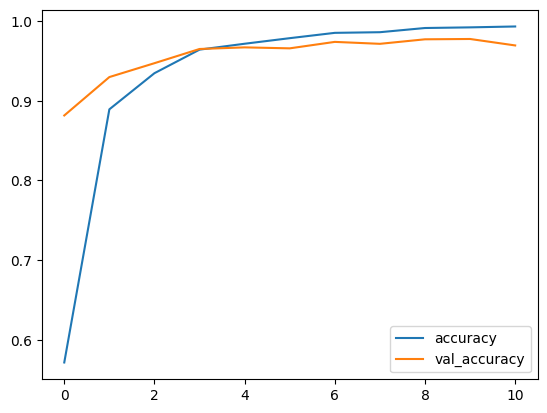

In [23]:
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [27]:
test_files = tf.io.gfile.glob(str('..\\..\\Python Projects\\VoiceCommandClassification\\DATA\\check_clear')+'/*/*.wav')
seed = 50
tf.random.set_seed(seed)
np.random.seed(seed)
filenames2 = tf.random.shuffle(test_files)
print(len(test_files))

200


In [28]:
test_ds = preprocess_dataset(test_files)

test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 76%


In [29]:
model_name = f"fmax{F_MIN}-fmin{F_MAX}-mels{N_MELS}-nfft{N_FFT}-hop{HOP_LENGTH}-tnum{train_num}-vnum{val_num}-{test_acc:.02}%"

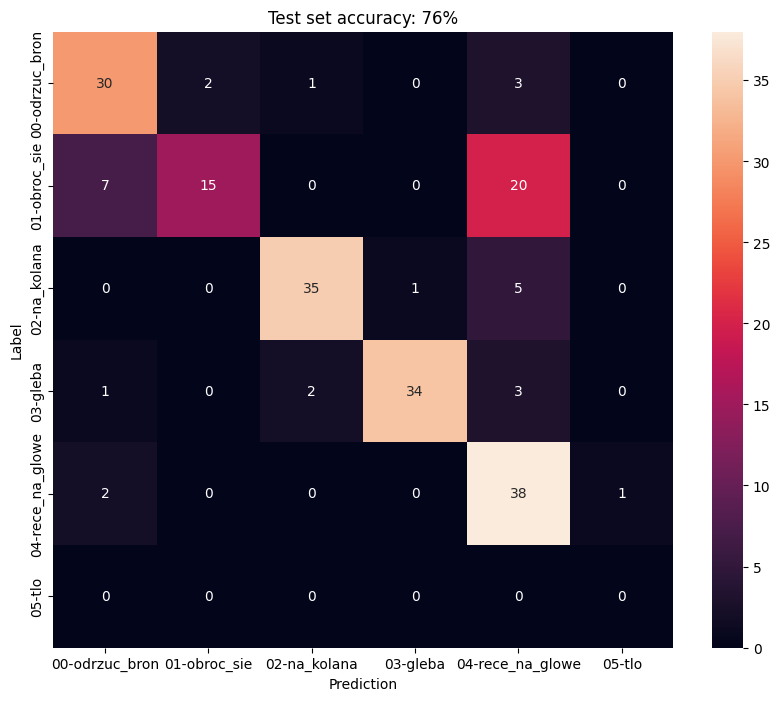

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=COMMANDS,
            yticklabels=COMMANDS,
            annot=True, fmt='g')
plt.title(f'Test set accuracy: {test_acc:.0%}')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig(model_name+".png", dpi=100)
plt.show()

In [47]:
model.save(model_name)

INFO:tensorflow:Assets written to: fmax100-fmin8000-mels128-nfft800-hop320-tnum0.7-vnum0.2-0.76%\assets


In [48]:
COMMANDS

array(['00-odrzuc_bron', '01-obroc_sie', '02-na_kolana', '03-gleba',
       '04-rece_na_glowe', '05-tlo'], dtype='<U16')